## 0b - Extend the timeseries to 5000 years for every region

Uses the scaled dataset to extend it to 5000 years everywhere. 

*this step has to happen after the notebook `0a_analysis_regional_model_dataset_merging_and_initial_state_comparison.ipynb`*. 

applied option: use the 101 last years and add them until the end of the timeseries. We use 101 years ecause that is more consistent with the rolling average of 101 years.


creates `../data/GMIP3_reg_glacier_model_data/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled_extended_repeat_last_101yrs.nc`
- dataset useful for plotting timeseries or steady-state estimates

---
other options that we thought of, but did not apply at the end: do a fit to interpolate until 5000 years, but this is not so straightforward and most likely not necessary because the regions that run only until simulation year 2000 mostly reached steady-state until then. 

In [3]:
DATE = 'Feb12_2024'
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path

import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from help_functions import pal_models, model_order, d_reg_num_name

try:
    #path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

except:
    # add your local path... 
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

fill_option = 'repeat_last_101yrs'

## Extend by using the last 101 years (because of long-term decadal variability ...)

In [7]:
import pymannkendall as mk

# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        


n_increasing = 0
n_decreasing = 0
n_no_trend = 0
deltaV_l = []
deltaV_l50 = []
ds_reg_models_extend = ds_reg_models.copy()
for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
    for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
        for m in np.arange(0, len(ds_reg_models_extend.model_author),1):

            ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
            #print(ds)
            for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).area_m2.values)):
                    # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                    pass
                #elif rgi_reg in rgi_regs_5000:
                #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                else:
                    # check that all are not nan-values! -> then do not need to extend
                    if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                        pass
                    else:
                        #try:
                        # check that it is really always np.NaN values after simulation year 2000 for that region
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        # Huss has area 0 for some regions 
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                        # fill them up with the last simulation year values 
                        # we fill that up that later 
                        #for y in np.arange(2001,5001):
                        if fill_option == 'last_value':
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).area_m2.values
                        elif fill_option == 'repeat_last_21yrs':  # 21-yr period is repeated ~142.9 times to fill up the additional 3000yrs
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).volume_m3.values, 143)[:3000]
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1980,2000)).area_m2.values, 143)[:3000]
                        elif fill_option == 'repeat_last_101yrs':  # 101-yr period is repeated ~29.7 times to fill up the additional 3000yrs
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3.values, 30)[:3000]
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).area_m2.values, 30)[:3000]
                        #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                        #except:
                        #    # ok some models did run over all regions for 5000 years
                        #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                        #    pass

                        dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,2000)).volume_m3
                        dendm = dend.mean(dim='simulation_year')
                        dendm_e = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1801,1900)).volume_m3.mean(dim='simulation_year')
                        deltaV_l.append((dendm.values-dendm_e.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))
                        mk_output = mk.original_test(dend, alpha=0.01)
                        if mk_output.trend =='no trend':
                            n_no_trend +=1
                        elif mk_output.trend =='decreasing':
                            n_decreasing +=1
                        elif mk_output.trend =='increasing':
                            n_increasing +=1
                        #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                        dend50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1951,2000)).volume_m3
                        dendm50 = dend50.mean(dim='simulation_year')
                        dendm_e50 = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1901,1950)).volume_m3.mean(dim='simulation_year')
                        deltaV_l50.append((dendm50.values-dendm_e50.values) / (ds.sel(rgi_reg =rgi_reg).volume_m3.sel(simulation_year=0).values))

            assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
            # add it to the big file 
            ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
            ds_reg_models_extend['area_m2'].data[m,gcm,:,:,period_scenario] = ds['area_m2'].values

ds_reg_models_extend.coords['extend_option'] = fill_option

# OGGM_v16 gave global estimates -> after extending the timeseries, there should be no NaN values left 
assert not np.any(np.isnan(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').values))

if fill_option == 'repeat_last_21yrs': 
    # check if values are all equal to the last 20 yr timeseries for a RGI region where there are no 
    for j in np.arange(0,3000,21):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1980,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2021+j)).isel(gcm=0).isel(period_scenario=0))

    for j in np.arange(0,3000,21):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(1980,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2021+j)).isel(gcm=0).isel(period_scenario=0))
elif fill_option == 'repeat_last_101yrs':
    print(fill_option)
     # check if values are all equal to the last 101 yr timeseries for a RGI region where there are no 
    for j in np.arange(0,2902,101):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2101+j)).isel(gcm=0).isel(period_scenario=0)
                                  )
    
    np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                   ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(4900,5000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                               rtol=1e-3
                                  )
    for j in np.arange(0,2902,101):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2101+j)).isel(gcm=0).isel(period_scenario=0)
                                  )
    np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                                   ds_reg_models_extend.volume_m3.sel(model_author='PyGEM-OGGM_v13').sel(rgi_reg='02').sel(simulation_year = slice(4900,5000)).isel(gcm=0).isel(period_scenario=0).mean(dim='simulation_year'),
                               rtol=1e-3
                                  )
    
ds_reg_models_extend.attrs['description'] = 'Scaled and extended regionally aggregated glacier model projections from GlacierMIP3 (volume and area).'
ds_reg_models_extend.attrs['postprocessing_phase'] = ('Volume scaled to match regional Farinotti et al. (2019) multi-model glacier volume estimate at the beginning, '
                                                'area scaled to match the RGI6.0 area at the beginning. Scaling done for each climate scenario and model time '
                                               'series (experiment) individually. For most experiments, scaling was not necessary as models aimed to match regional '
                                               'volume/area, and upscaled already internally. In addition, where necessary, the experiments are extended from the year '
                                               '2000 to the year 5000. More in Methods and Supplementary Data Table 2 of Zekollari and Schuster et al., submitted') 
ds_reg_models_extend.attrs['dataset_version'] = 'v1.0'
ds_reg_models_extend.attrs['source'] = 'Data from Glacier Model Intercomparison Project Phase 3 (GlacierMIP3), https://doi.org/10.5281/zenodo.14045269'
ds_reg_models_extend.attrs['contact'] = 'lilian.schuster@uibk.ac.at, harry.zekollari@vub.be' 

try:
    ds_reg_models_extend.to_netcdf(f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')
    ds_reg_models_extend.to_netcdf(f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')
except:
    ds_reg_models_extend.to_netcdf(f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')

repeat_last_101yrs


In [8]:
# there are still a few simulations with signigicant trends, but it doesn't make sense to correct here
# as anyways climate is not stable over such long periods even without antropogenic changes...
n_no_trend, n_decreasing, n_increasing

(2239, 389, 252)

In [10]:
# ratio of experiments and models going for 2000 years which are not stabilising after ~2000 years 
len(np.array(deltaV_l)[list(np.abs(deltaV_l)>0.01)])/len(deltaV_l)

0.01875

### Using a fit instead as extension?
- this is not so straightforward, as most fits are not working very well (and we would need to find one that works on every simulation). Therefore, we decided to not use that approach. If you are interested, you can still have a look into the code below. 

/tmp/ipykernel_671031/2453980801.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x))


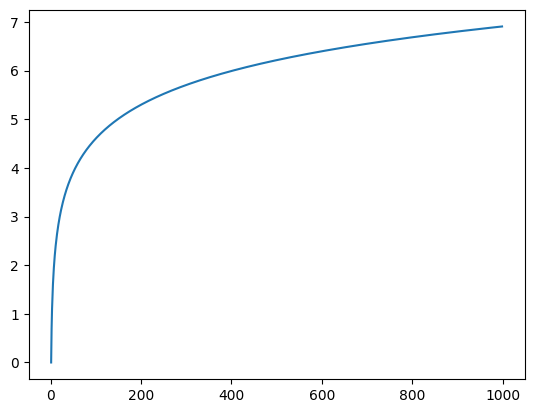

In [6]:
x=np.arange(0,1000,1)
plt.plot(np.log(x))

In [7]:
n_total = n_increasing+ n_increasing+n_no_trend
n_increasing/n_total

0.12705882352941175

In [8]:
n_decreasing/n_total

0.15899159663865547

In [9]:
dend = ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0)
dall = ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(0,2000)).isel(gcm=0).isel(period_scenario=0)
mk_output = mk.original_test(dend, alpha=0.01)
mk_output

Mann_Kendall_Test(trend='increasing', h=True, p=2.08909639254351e-06, z=4.7446088308081515, Tau=0.3203960396039604, s=1618.0, var_s=116150.0, slope=300303703.2010944, intercept=4719902094583.945)

In [98]:
import scipy

In [ ]:
import pymannkendall as mk

def func(x, a, b,c,d,e): # x-shifted log
    return (a*np.exp(-b*x**d)+c)/e

from scipy.optimize import curve_fit

# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        
# expand the rgi regions that only run until 2000 by using the last simulated year
n_increasing = 0
n_decreasing = 0
n_no_trend = 0
fill_option = 'fit'

ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
ds_reg_models_extend = ds_reg_models.copy()
for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
    for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
        for m in np.arange(0, len(ds_reg_models_extend.model_author),1):
        
            ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
            #print(ds)
            for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).area_m2.values)):
                    # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                    pass
                #elif rgi_reg in rgi_regs_5000:
                #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                else:
                    # check that all are not nan-values! -> then do not need to extend
                    if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                        pass
                    else:
                        #try:
                        # check that it is really always np.NaN values after simulation year 2000 for that region
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        # Huss has area 0 for some regions 
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                        # fill them up with the last simulation year values 
                        # we fill that up that later 
                        #for y in np.arange(2001,5001):
                        if fill_option == 'last_value':
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).area_m2.values
                        elif fill_option == 'repeat_last_20yrs':  # 20-yr period is repeated 150 times to fill up the additional 3000yrs
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).volume_m3.values, 150)
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).area_m2.values, 150)
                        elif fill_option =='fit':
                            # let's only take the years 1000 to 2000
                            skip_yrs = 1000
                            dall = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(skip_yrs,2000))
                            #dall = ds_reg_models_extend.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(0,2000)).isel(gcm=0).isel(period_scenario=0)

                            ### volume
                            p0 = [-dall.volume_m3.max(), 1, dall.volume_m3.max(),1,1]
                            fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.volume_m3.values, p0 = p0)
                            t = np.arange(skip_yrs,5001,1)
                            d_fit_volume_m3 = func(t, *fittedParameters) 
                            np.testing.assert_allclose(dall.volume_m3.values[:2000-skip_yrs], 
                                                       d_fit_volume_m3[0:2000-skip_yrs], rtol=0.1)
                            # area
                            p0 = [-dall.area_m2.max(), 1, dall.area_m2.max(),1,1]
                            fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.area_m2.values, p0 = p0)
                            t = np.arange(skip_yrs,5001,1)
                            d_fit_area_m2 = func(t, *fittedParameters) 
                            np.testing.assert_allclose(dall.area_m2.values[:2000-skip_yrs], 
                                                       d_fit_area_m2[:2000-skip_yrs], rtol=0.1)
                            
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = d_fit_volume_m3[2000-skip_yrs+1:]
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = d_fit_area_m2[2000-skip_yrs+1:]
                        #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                        #except:
                        #    # ok some models did run over all regions for 5000 years
                        #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                        #    pass
                        
                        dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3
                        mk_output = mk.original_test(dend, alpha=0.01)
                        if mk_output.trend =='no trend':
                            n_no_trend +=1
                        elif mk_output.trend =='decreasing':
                            n_decreasing +=1
                        elif mk_output.trend =='increasing':
                            n_increasing +=1
                        #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

            assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
            # add it to the big file 
            ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
            ds_reg_models_extend['area_m2'].data[m,gcm,:,:,period_scenario] = ds['area_m2'].values
            
ds_reg_models_extend.coords['extend_option'] = fill_option

**below you can see one of the issues**

/tmp/ipykernel_3102955/2645228258.py:4: RuntimeWarning: overflow encountered in power
  return (a*np.exp(-b*x**d)+c)/e
/tmp/ipykernel_3102955/2645228258.py:4: RuntimeWarning: overflow encountered in exp
  return (a*np.exp(-b*x**d)+c)/e
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


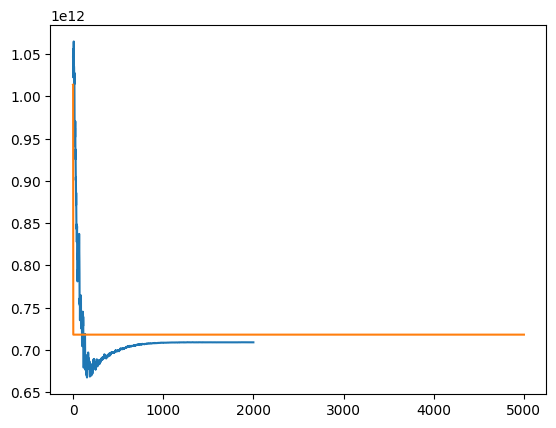

In [313]:
p0 = [-dall.volume_m3.max(), 1, dall.volume_m3.max(),1,1]
fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.volume_m3.values, p0 = p0)
t = np.arange(0,5001,1)
d_fit_volume_m3 = func(t, *fittedParameters) 

plt.plot(dall.volume_m3)

plt.plot(t,d_fit_volume_m3)

[-2.25290996e+12  1.32947258e-02  6.59375456e+12  7.45563511e-01
  1.38590735e+00]


/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


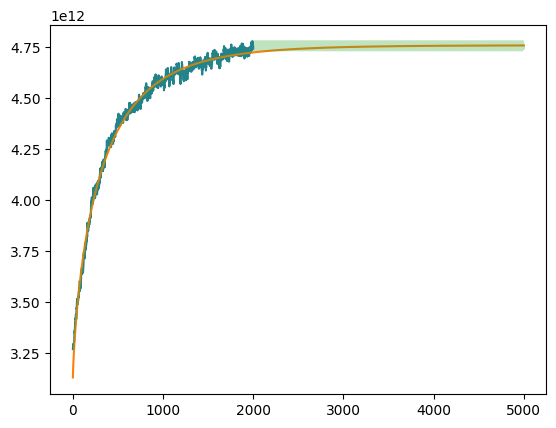

In [294]:


print(fittedParameters)
#absError = modelPredictions - yData

#SE = numpy.square(absError) # squared errors
#MSE = numpy.mean(SE) # mean squared errors
#RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
#Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

t = np.arange(0,5001,1)
modelPredictions = func(t, *fittedParameters) 
plt.plot(dall.simulation_year, )
plt.plot(t,modelPredictions)

plt.plot(t, ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').isel(gcm=0).isel(period_scenario=0), alpha = 0.3)

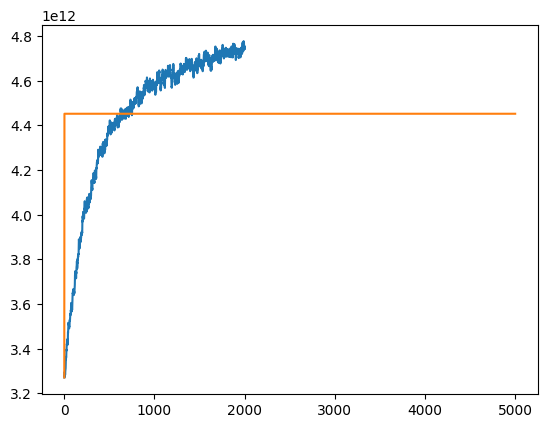